# **Spam link detection system**
### We want to implement a system that is able to automatically detect whether a web page contains spam or not based on its URL.

In [18]:
# Import the libraries
import pandas as pd
import regex as re
from pickle import dump
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

### **Step 1:** Loading the dataset

In [2]:
# Load the dataset from https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv
url_spam_ds = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv")
url_spam_ds.to_csv("../data/raw/url_spam.csv", mode='w')
url_spam_ds

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True
...,...,...
2994,https://www.smartcitiesworld.net/news/news/dee...,False
2995,https://www.youtube.com/watch,True
2996,https://techcrunch.com/2019/07/04/an-optimisti...,False
2997,https://www.technologyreview.com/2019/12/20/13...,False


### **Step 2:** Preprocess the links

In [3]:
# Find duplicates
if url_spam_ds.duplicated().sum():
    url_spam_ds = url_spam_ds.drop_duplicates()
print(url_spam_ds.shape)
url_spam_ds

(2369, 2)


,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True
...,...,...
2993,https://www.theverge.com/2020/6/29/21306889/di...,False
2994,https://www.smartcitiesworld.net/news/news/dee...,False
2996,https://techcrunch.com/2019/07/04/an-optimisti...,False
2997,https://www.technologyreview.com/2019/12/20/13...,False


In [4]:
# Transform the categories "true" and "false" into numerical values (1 and 0)
url_spam_ds.loc[url_spam_ds["is_spam"] == 'False', "is_spam"] = 0
url_spam_ds.loc[url_spam_ds["is_spam"] == 'True', "is_spam"] = 1
url_spam_ds["is_spam"] = url_spam_ds["is_spam"].astype(int)
url_spam_ds.head()

C:\Users\fevc_\AppData\Local\Temp\ipykernel_14700\2614666407.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  url_spam_ds.loc[url_spam_ds["is_spam"] == 'False', "is_spam"] = 0
C:\Users\fevc_\AppData\Local\Temp\ipykernel_14700\2614666407.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  url_spam_ds["is_spam"] = url_spam_ds["is_spam"].astype(int)


,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


In [5]:
# Text processing

# Define the function preprocess_text
def preprocess_text(text):
    # Remove any character that is not a letter (a-z) or white space ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Remove white spaces
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Multiple white spaces into one
    text = re.sub(r'\s+', " ", text.lower())

    # Remove tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

url_spam_ds["url"] = url_spam_ds["url"].apply(preprocess_text)
url_spam_ds.head()

C:\Users\fevc_\AppData\Local\Temp\ipykernel_14700\2882289803.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  url_spam_ds["url"] = url_spam_ds["url"].apply(preprocess_text)


,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com, v, i]",1
3,"[https, briefingday, com, m, commentform]",0
4,"[https, briefingday, com, fan]",1


In [6]:
# Lemmatization of the text

download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

url_spam_ds["url"] = url_spam_ds["url"].apply(lemmatize_text)
url_spam_ds.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fevc_\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fevc_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\fevc_\AppData\Local\Temp\ipykernel_14700\1605911624.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  url_spam_ds["url"] = url_spam_ds["url"].apply(lemmatize_text)


,url,is_spam
0,"[http, briefingday, list, manage, unsubscribe]",1
1,"[http, hvper]",1
2,"[http, briefingday]",1
3,"[http, briefingday, commentform]",0
4,"[http, briefingday]",1


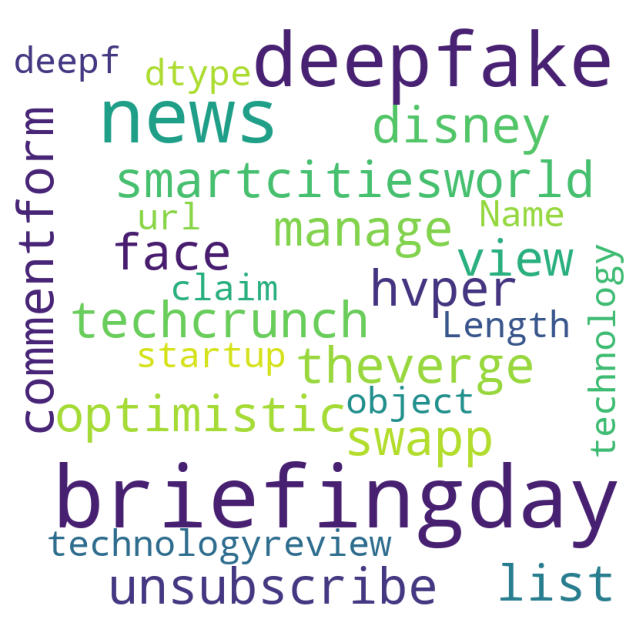

In [7]:
# Visual representation of the tokens
wordcloud = WordCloud(width = 800, height = 800, background_color = "white", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(url_spam_ds["url"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [8]:
# Trnsform text into numeric vectors
tokens_list = url_spam_ds["url"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = url_spam_ds["is_spam"]

X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### **Step 3:** Build an SVM

In [10]:
# Create and train the model
model = SVC(random_state = 42)
model.fit(X_train, y_train)

SVC(random_state=42)

In [11]:
# Model prediction
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [12]:
# Measure the effectiveness
accuracy_score(y_test, y_pred)

0.9620253164556962

### **Step 4:** Optimize the previous model

In [13]:
# Model optimization with hyperparameter
# Create the hyperparameter grid
param_grid = {
    "C": [0.001, 0.01, 0.1, 1.0],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"],
    "degree": [1, 2, 3]
}

# Create the GridSearchCV object
grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# fit the model
grid.fit(X_train, y_train)

# best hyperparameters
print(f'Best hyperparameters: {grid.best_params_}')

Best hyperparameters: {'C': 1.0, 'degree': 1, 'gamma': 'scale', 'kernel': 'linear'}


In [14]:
# best model
best_model = SVC(C = 1.0, degree = 1, gamma = "scale", kernel = "linear", random_state = 42)
best_model.fit(X_train, y_train)

SVC(degree=1, kernel='linear', random_state=42)

In [15]:
# Best model prediction
y_pred = best_model.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [16]:
# acurracy of the best model
accuracy_score(y_test, y_pred)

0.9514767932489452

### **Step 5:** Save the model

In [19]:
# Save the models
dump(model, open('../models/svc_default.sav', 'wb'))
dump(best_model, open('../models/svc_C-1.0_degree-1_gamma-scale_kernel-linear_42.sav', 'wb'))